In [31]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

from sklearn.metrics import mean_squared_error as calc_rmse


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_redo_pbe0dz_pc.pkl")

In [119]:
data.data

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
0,10.30112,-82.11234,27.55810,test467,-1527.187866,20,-1527.328541,-88.274060,-958403.241564
1,11.34510,-93.28769,29.22768,test263,-1527.183081,20,-1527.326127,-89.762384,-958401.726960
2,11.00067,-77.72898,32.02998,test35,-1527.185703,20,-1527.300030,-71.740517,-958385.350512
3,10.80442,-71.94916,29.97665,test223,-1527.186209,20,-1527.289994,-65.125035,-958379.052942
4,10.92780,-79.63452,16.86211,test254,-1527.186066,20,-1527.331554,-91.293912,-958405.132180
...,...,...,...,...,...,...,...,...,...
495,12.22319,-77.94768,22.40034,test100,-1527.183347,20,-1527.307506,-77.910277,-958390.041931
496,10.84565,-93.69849,32.56187,test304,-1527.190149,20,-1527.335938,-91.482928,-958407.882889
497,11.03942,-60.99375,19.52537,test327,-1527.185234,20,-1527.278286,-58.390447,-958371.706595
498,11.90470,-81.86875,25.81878,test185,-1527.187380,20,-1527.319985,-83.210129,-958397.872447


In [36]:
data_ = data.data
data_.index = data_.KEY

In [37]:
structure = "water_redo"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 500 500


In [50]:
data_.sort_values("intE")

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
test76,11.33225,-67.56906,11.86175,test76,-1450.824462,19,-1527.317213,-47999.431132,-958396.133272
test4,10.27541,-109.19208,27.26727,test4,-1527.185213,20,-1527.382846,-124.015319,-958437.318158
test397,10.15704,-95.40840,18.62454,test397,-1527.183434,20,-1527.373442,-119.230703,-958431.417007
test67,9.67477,-102.99200,23.40678,test67,-1527.186353,20,-1527.375924,-118.956698,-958432.974463
test151,9.62300,-101.83325,25.87094,test151,-1527.186545,20,-1527.372006,-116.377171,-958430.516032
...,...,...,...,...,...,...,...,...,...
test365,12.55191,-63.82734,15.50390,test365,-1527.183359,20,-1527.276873,-58.680177,-958370.819613
test327,11.03942,-60.99375,19.52537,test327,-1527.185234,20,-1527.278286,-58.390447,-958371.706595
test177,11.16631,-54.76676,11.94163,test177,-1527.184798,20,-1527.275996,-57.226912,-958370.269331


In [39]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

array([[<AxesSubplot:title={'center':'TOTAL'}>,
        <AxesSubplot:title={'center':'ELEC'}>,
        <AxesSubplot:title={'center':'VDW'}>],
       [<AxesSubplot:title={'center':'M_ENERGY'}>,
        <AxesSubplot:title={'center':'n_monomers'}>,
        <AxesSubplot:title={'center':'C_ENERGY'}>],
       [<AxesSubplot:title={'center':'intE'}>,
        <AxesSubplot:title={'center':'C_ENERGY_kcalmol'}>,
        <AxesSubplot:>]], dtype=object)

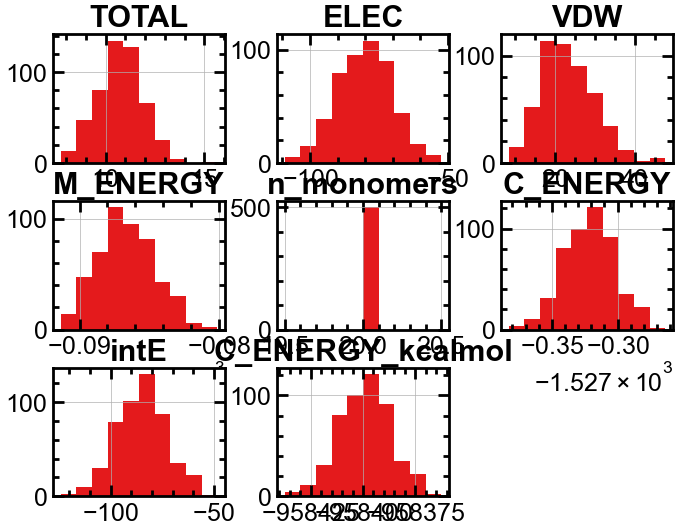

In [54]:
# dists.keys()
data_.sort_values("intE")[1:].hist()

In [111]:
ljpcff = FF(
    data_.sort_values("intE")[1:], # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff.num_segments = len(ljpcff.data)
print("Nsegments", ljpcff.num_segments)
ljpcff.set_targets()

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0    -84.637925
test1    -77.735360
test10   -95.064088
test11   -97.757619
test12   -78.933784
test13   -83.808636
test14   -71.344336
test15   -82.052976
test16   -90.358079
test17   -65.927379
test18   -93.429267
test19   -77.414951
test2    -90.019409
test20   -78.403846
test3    -91.516964
test4    -66.347298
test5    -88.904776
test7    -74.328571
test8    -85.461648
test9    -85.440187
Name: intE, dtype: float64
count    20.000000
mean    -82.944355
std       9.106118
min     -97.757619
25%     -90.104077
50%     -84.223280
75%     -77.655258
max     -65.927379
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [2.4400557062085055, 3.1977418178762553, 0.7542028951170738, 0.18516805411375073]
sig [4.880111

In [116]:
ljpcff

FF: LJ water_test ELEC Exact intE (jax_coloumb: False)

In [117]:
ljpcff.targets

Array([ -8.164207  ,   7.982338  ,  -5.2890244 , -17.826645  ,
       -11.016838  ,  -4.7672653 ,   0.23591614,  -9.744667  ,
        -3.774826  ,  -3.8736153 , -15.249596  ,   3.1655655 ,
        -3.9843216 ,  -1.3100967 ,  -8.166908  ,  -5.2575264 ,
        -1.257904  ,  -8.949844  ,   0.2954712 ,  -6.629219  ],      dtype=float32)

In [114]:
ljpcff_fit = fit_repeat(ljpcff,
             1,
             "test",
             loss="jax",
            quiet=True)

loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_test ELEC Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_test ELEC Exact intE (jax_coloumb: False)>)


In [115]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
0,23.678699,183,338,0,True,Optimization terminated successfully.,"[1.0518924000705097, 1.149489037475472, 0.0999...","([[1.0518924000705097, 1.149489037475472, 0.09..."


#  New structures

In [68]:
data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_test_pbe0dz_pc.pkl")
# data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_redo_pbe0dz_pc.pkl")

In [69]:
data_ = data.data
data_.index = data_.KEY

In [70]:
structure = "water_test"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 21 21


In [71]:
data_

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
test8,12.60002,-85.75712,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462
test18,10.64131,-78.17967,17.58907,test18,-1527.187973,20,-1527.336863,-93.429267,-958408.463825
test13,10.93537,-79.04137,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715
test17,11.86569,-62.05376,20.71719,test17,-1527.186904,20,-1527.291967,-65.927379,-958380.291388
test0,11.02944,-76.47372,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538
test15,9.56544,-72.30831,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655
test6,10.11763,-93.13948,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680
test1,10.63645,-85.71770,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428
test12,8.69738,-67.91695,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611


In [72]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

In [74]:
ljpcff_test = FF(
    data_, # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff_test.num_segments = len(data_)
print("Nsegments", ljpcff_test.num_segments)
ljpcff_test.set_targets()

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0    -84.637925
test1    -77.735360
test10   -95.064088
test11   -97.757619
test12   -78.933784
test13   -83.808636
test14   -71.344336
test15   -82.052976
test16   -90.358079
test17   -65.927379
test18   -93.429267
test19   -77.414951
test2    -90.019409
test20   -78.403846
test3    -91.516964
test4    -66.347298
test5    -88.904776
test6    -99.635761
test7    -74.328571
test8    -85.461648
test9    -85.440187
Name: intE, dtype: float64
count    21.000000
mean    -83.739184
std       9.593859
min     -99.635761
25%     -90.358079
50%     -84.637925
75%     -77.735360
max     -65.927379
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [3.945532794977745, 1.9828604667035397, 0.03699140378597432, 0.702136145224

In [98]:
ljpcff.data["ELEC"]

KEY
test0     -73.94634
test1     -83.35414
test10    -79.27778
test100   -77.94768
test101   -89.77301
             ...   
test95    -86.42341
test96    -84.82890
test97    -84.20876
test98    -78.31094
test99    -89.39532
Name: ELEC, Length: 499, dtype: float64

In [103]:
ljpcff.eval_best_parm().to_numpy().shape

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


(499, 1)

In [106]:
ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"]

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


KEY
test0     -77.760952
test1     -86.725617
test10    -84.536006
test100   -82.017459
test101   -95.755946
             ...    
test95    -91.042340
test96    -89.251839
test97    -88.812263
test98    -89.072288
test99    -89.370491
Name: ELEC, Length: 499, dtype: float64

In [78]:
ffeval = ljpcff_test.eval_jax(ljpcff.get_best_parm())[0]

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


Text(0, 0.5, 'FF ENERGY [kcal/mol]')

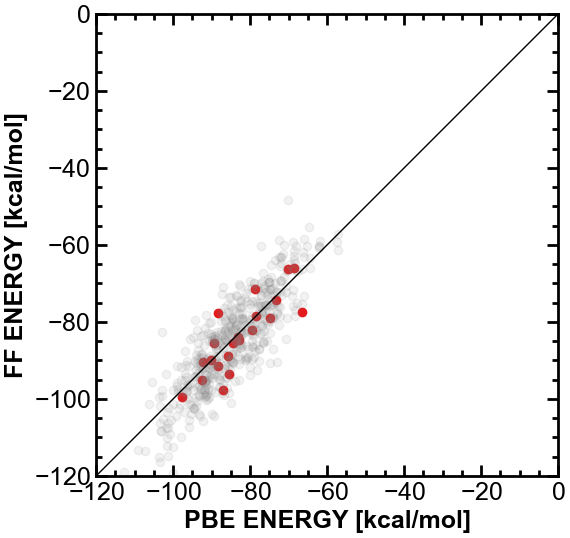

In [107]:
plt.scatter(ffeval + ljpcff_test.data["ELEC"], ljpcff_test.targets + ljpcff_test.data["ELEC"])
plt.scatter(ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"], ljpcff.targets + ljpcff.data["ELEC"] , alpha=0.1, color="gray")

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")


In [80]:
# a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])
# a,b,c = ljpcff.eval_jax([ 0.1, 0.1, 0.36058475, 1.74046017,])

In [94]:
np.sqrt(calc_rmse(
ffeval + ljpcff_test.data["ELEC"], ljpcff_test.targets + ljpcff_test.data["ELEC"]
))

5.1745996

In [96]:
np.sqrt(calc_rmse(
ffeval + ljpcff_test.data["ELEC"], ljpcff_test.data["intE"]
))

5.174599744834649

In [95]:
np.std((ffeval+ ljpcff_test.data["ELEC"]) - (ljpcff_test.targets+ ljpcff_test.data["ELEC"]))

5.080096

In [108]:
np.sqrt(calc_rmse(
ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"], ljpcff.data["intE"]
))

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


6.453235842987552

In [109]:
np.std((ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"]) -  ljpcff.data["intE"])

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


6.44566904083483

In [20]:
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT

In [21]:
# tip3
a,b,c = ljpcff.eval_jax([ 
        0.2245,
        1.7682, 
        0.0460, 
        0.1521, 
])
a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])

In [22]:
a

Array([ 9.251455 , 14.777982 , 10.30091  ,  8.400745 ,  4.299672 ,
       10.247934 , 10.167942 ,  5.652323 , 11.281921 ,  7.8529425,
        6.4905353, 12.583264 ,  9.460383 , 11.551605 , 10.802073 ,
        3.6021059, 17.105726 , 11.182094 ,  5.8501616, 13.645883 ,
        9.839243 ], dtype=float32)

In [23]:
a_,b_,c_ = FFOBJ.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])

In [24]:
# ljpcff.data

(array([2., 0., 1., 4., 4., 4., 3., 1., 1., 1.]),
 array([-17.826645 , -15.245747 , -12.664848 , -10.08395  ,  -7.5030518,
         -4.9221535,  -2.3412552,   0.2396431,   2.8205414,   5.4014397,
          7.982338 ], dtype=float32),
 <BarContainer object of 10 artists>)

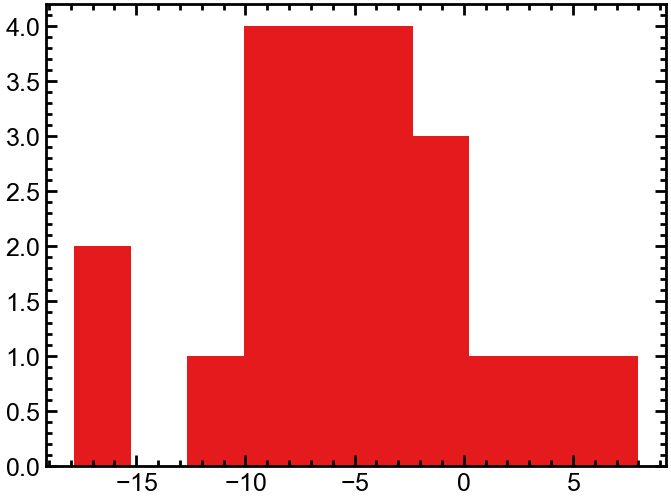

In [25]:
plt.hist(ljpcff.targets)

In [26]:
datacopy = ljpcff.data.copy()
datacopy["fitE"] = a
datacopy["target"] = ljpcff.targets
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
KEY,,,,,,,,,,,,
test0,11.02944,-76.47372,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,9.251455,-8.164207
test1,10.63645,-85.71770,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,14.777982,7.982338
test10,10.09662,-89.77506,24.00860,test10,-1527.187550,20,-1527.339045,-95.064088,-958409.833043,0.0,10.300910,-5.289024
test11,9.97533,-79.93098,20.57407,test11,-1527.188313,20,-1527.344101,-97.757619,-958413.005378,0.0,8.400745,-17.826645
test12,8.69738,-67.91695,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611,0.0,4.299672,-11.016838
test13,10.93537,-79.04137,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715,0.0,10.247934,-4.767265
test14,10.62310,-71.58025,24.96655,test14,-1527.189420,20,-1527.303115,-71.344336,-958387.286722,0.0,10.167942,0.235916
test15,9.56544,-72.30831,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655,0.0,5.652323,-9.744667
test16,12.68634,-86.58325,25.73819,test16,-1527.184128,20,-1527.328125,-90.358079,-958402.980158,0.0,11.281921,-3.774826


In [27]:
datacopy = datacopy.loc[ ["test0",
"test1",
"test2",
"test3",
"test4",
"test5",
"test6",
"test7",
"test8",
"test9",
"test10",
"test11",
"test12",
"test13",
"test14",
"test15",
"test16",
"test17",
"test18",
"test19",]]
datacopy["EPOL"] = polE

In [28]:
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target,EPOL
KEY,,,,,,,,,,,,,
test0,11.02944,-76.47372,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,9.251455,-8.164207,-13.711463
test1,10.63645,-85.71770,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,14.777982,7.982338,-13.113444
test2,10.62982,-86.03509,21.05558,test2,-1527.187648,20,-1527.331104,-90.019409,-958404.850004,0.0,9.460383,-3.984322,-12.595535
test3,10.46860,-83.35005,24.12367,test3,-1527.188524,20,-1527.334367,-91.516964,-958406.897045,0.0,10.802073,-8.166908,-14.095311
test4,11.90133,-61.08977,13.29071,test4,-1527.183458,20,-1527.289190,-66.347298,-958378.548486,0.0,3.602106,-5.257526,-7.846198
test5,10.60922,-87.64687,32.48558,test5,-1527.188095,20,-1527.329776,-88.904776,-958404.016178,0.0,17.105726,-1.257904,-12.722443
test6,10.11763,-93.13948,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680,0.0,11.182094,-6.496277,-15.185254
test7,11.02849,-65.37872,16.73097,test7,-1527.185562,20,-1527.304014,-74.328571,-958387.850459,0.0,5.850162,-8.949844,-10.552431
test8,12.60002,-85.75712,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462,0.0,13.645883,0.295471,-16.058389


In [29]:
np.sqrt(calc_rmse(
    ljpcff.data.intE,
    a + ljpcff.data.ELEC
))

15.590667359517822

In [36]:
np.std(ljpcff.data.intE
    - (a + ljpcff.data.ELEC))

4.345984816189061

In [30]:
np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
))

4.606499708645817

In [31]:
np.sqrt(calc_rmse(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC))

5.655035133460915

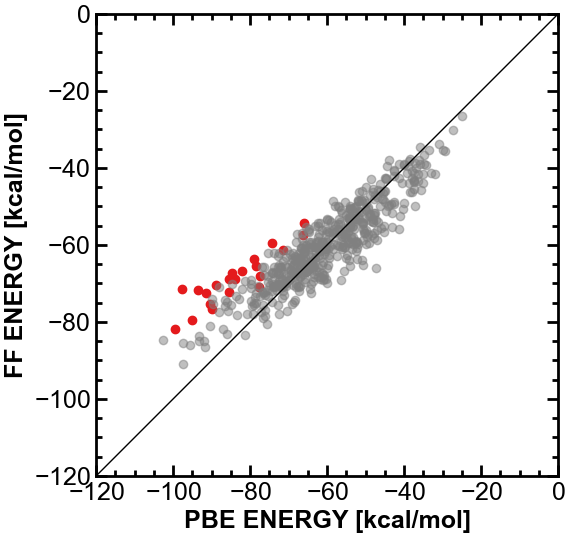

In [32]:
plt.scatter(
            ljpcff.data.intE,
            a + ljpcff.data.ELEC, 
           )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC,  c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_test.png")

In [199]:
datacopy.ELEC + datacopy.EPOL

KEY
test0     -90.185183
test1     -98.831144
test2     -98.630625
test3     -97.445361
test4     -68.935968
test5    -100.369313
test6    -108.324734
test7     -75.931151
test8    -101.815509
test9     -92.246431
test10   -105.932221
test11    -94.888240
test12    -80.167325
test13    -91.430018
test14    -83.876379
test15    -83.656513
test16   -100.168548
test17    -72.367368
test18    -91.562326
test19    -95.744461
dtype: float64

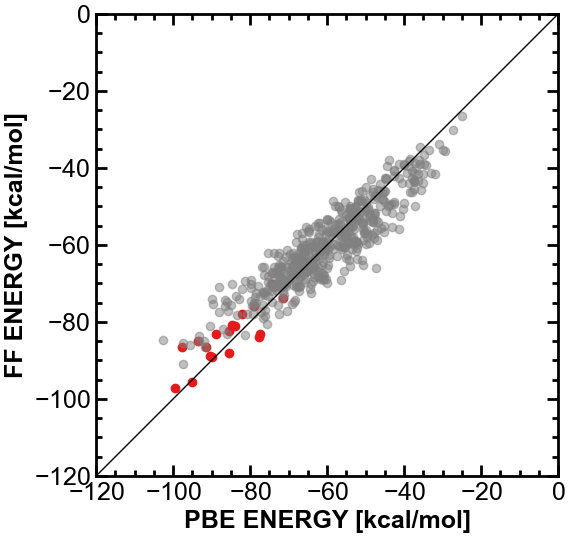

In [200]:
plt.scatter(datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
            )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC, c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_pol_test.png")